# How to use $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Representations of $\mathrm{SO}(2)$**
    - I.1. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^4$
    - I.2. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^6$
    - I.3. PCA pre-processing
- **II. Representations of $T^2$**
    - II.1. Representation of $T^2$ in $\mathbb{R}^6$
    - II.2. Representation of $T^2$ in $\mathbb{R}^8$
- **III. Representations of $T^3$**
    - III.1. Representation of $T^3$ in $\mathbb{R}^8$
    - III.2. Representation of $T^3$ in $\mathbb{R}^{10}$
- **IV. Representations of $\mathrm{SU(2)}$ and $\mathrm{SO}(3)$**
    - IV.1. Representation of $\mathrm{SO}(3)$ in $\mathbb{R}^5$
    - IV.2. Representation of $\mathrm{SU}(2)$ in $\mathbb{R}^7$
- **V. Additional experiments**
    - V.1. Comparison of two candidates: $\mathrm{SO}(3)$ and $T^3$ in $\mathbb{R}^6$
    - V.2. Non-transitive action: Möbius strip $\mathbb{R}^4$

**Note:** Our algorithm may not converge every time, therefore it may be necessary to run it multiple times to obtain satisfactory results. This is due to the possibility of getting stuck in local minimum, while using the *Stiefel* of *Grassmann* method.

In [1]:
from functions_20240715 import*

2024-07-23 12:41:35.072940: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 12:41:35.077524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-23 12:41:35.077538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# I. Representations of $\mathrm{SO}(2)$

## I.1. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^4$

Our first example is a representation of $\mathrm{SO}(2)$ in dimension $4$.
We wish to recover the weights of the representation. In the next cell, we generate the point cloud. It is drawn uniformly on the orbit of a representation of $\mathrm{SO}(2)$, whose decomposition into irreps is also drawn randomly. Here, the representation is chosen almost-faithful, and composed of distinct irreps, so that the orbit spans the whole space $\mathbb{R}^4$. For visualization purpose, all figures are projections in dimension $3$.

-----> Representation of T^1 in R^4 with frequencies ((-2, 4),)


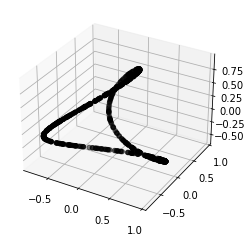

In [2]:
' Generate dataset '

# Parameters
ambient_dim = 4     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 4   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');

Next, we apply Lie-PCA. Two methods are available: with local covariance, that do not use pruning of the eigenvectors, and with local PCA, that does. On both methods, we already see that the Lie-PCA operator has one significantly small eigenvalue. This is an indicator of the fact that the underlying orbit is generated by $\mathrm{SO}(2)$.

----> Lie PCA with localcovariance estimation of tangent spaces <----
First eigenvalues: [0.00014877373438025224, 0.11507074247343876, 0.12138978597899044, 0.12540286286176347]
Eigengap #1: 773.461410730797


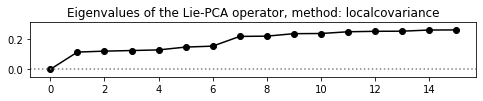

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.00014824336134382628, 0.11529027326117053, 0.12157259249942147, 0.12556672760957704]
Eigengap #1: 777.7095191046941


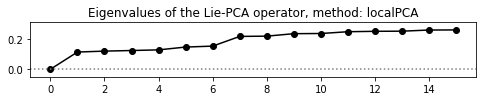

In [3]:
' Lie-PCA '

n_neighbors = 10
method='localcovariance'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator, method: '+method);
plt.show();

method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator, method: '+method);
plt.show();

We now find the Lie algebra more likely to generate the orbit underlying the point cloud, based on the Lie-PCA operator. 
To this end, we implemented three methods: the first two methods consist in an optimisation over $\mathrm{O}(n)$, and the last one is based in the normal form decomposition of the skew-symmetric matrices.
We see that the three methods allow to recover exactly the frequencies, and give an accurate estimation of the underlying orbit.

----> Optimization problem via Stiefel for torus group <----
Number of frequencies to test: 5
Solve minimization problem... It 5/5. Duration 0:00:36 Expected remaining time 0:00:00.
The optimal frequencies found is ((1, 2),) with cost 2.2496253147793558e-07
----> The frequencies ((-2, 4),) and ((1, 2),) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.01


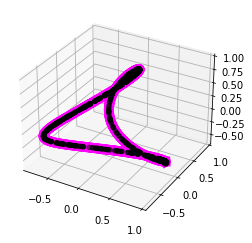

----> Optimization problem via Grassmann for torus group <----
Number of frequencies to test: 5
Solve minimization problem... It 5/5. Duration 0:00:06 Expected remaining time 0:00:00.
The optimal frequencies found is ((1, 2),) with cost 8.068813807413461e-07
----> The frequencies ((-2, 4),) and ((1, 2),) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0108


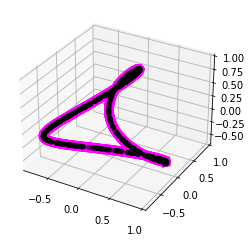

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 5
The optimal frequencies found is ((1, 2),) with cost 0.0006351697468312202
----> The frequencies ((-2, 4),) and ((1, 2),) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0108


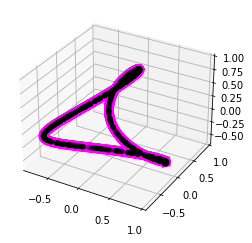

In [4]:
' Project on Lie subalgebras '

for method in ['Stiefel', 'Grassmann', 'NormalForm']:
    # Find frequencies
    OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                                  method=method,verbosity=1)
    
    # Check if found frequencies are correct
    AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

    ' Plot orbit '

    # Generate estimated orbit
    n_points_orbit = 500
    x = X[0,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))
    
    # Plot dataset
    Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
    fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
    ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=50)

    # Plot estimated orbit
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show();

## I.2. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^6$

We reproduce the same experiment, $\mathrm{SO}(2)$ being now represented in dimension $6$.

-----> Representation of T^1 in R^6 with frequencies ((-4, -3, -1),)


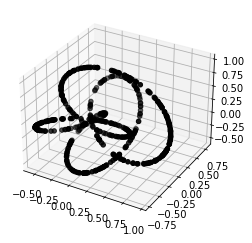

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0003733803211418027, 0.0766303557837641, 0.0786632788101197, 0.08562185021380599]
Eigengap #1: 205.23405076471977


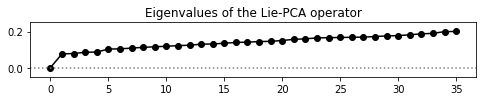

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 4
The optimal frequencies found is ((1, 3, 4),) with cost 0.002192385504043543
----> The frequencies ((-4, -3, -1),) and ((1, 3, 4),) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0189


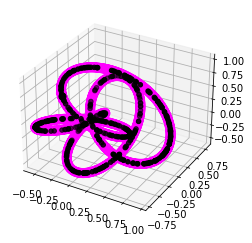

In [5]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 4   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black'); plt.show();

' Lie-PCA '

n_neighbors = 10
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'NormalForm'

# Find frequencies
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 500
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot dataset
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=50)

# Plot estimated orbit
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show();

## I.3. PCA pre-processing

The consistency of our method is based on the assumption that the underlying orbit lives in a minimal-dimensional subspace. If not, the isometry group $\mathrm{Isom}(\mathcal{O})$ is not equal to the symmetry group $\mathrm{Sym}(\mathcal{O})$, and our algorithm may return inconsistent Lie algebras.
This is the case for the point cloud below, where the representation has weights $(1,1,2)$.

-----> Representation of T^1 in R^6 with frequencies ((1, 1, 2),)


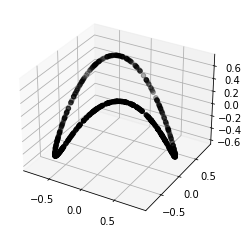

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [-1.2225801292663437e-16, -7.385202300184037e-17, -5.2260954959294165e-17, -5.054880922370668e-17]
Eigengap #1: 0.6040669338062784


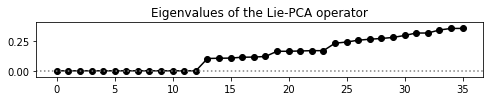

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 4
The optimal frequencies found is ((1, 2, 4),) with cost 0.45171579513380444
----> The frequencies ((1, 1, 2),) and ((1, 2, 4),) are not equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 1.0671


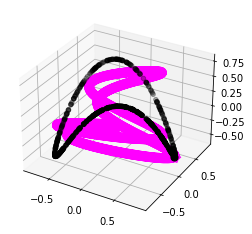

In [6]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 1             # dimension of the torus (here, circle)
n_points = 500      # number of sample points
frequency_max = 4   # maximal angle parameter
Frequencies = ((1,1,2),) # prescribed frequencies

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True,
                                           frequencies=Frequencies)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black'); plt.show();

' Lie-PCA '

n_neighbors = 10
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'NormalForm'

# Find frequencies
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 500
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot dataset
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=50)

# Plot estimated orbit
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show();

In order to remedy to this problem, we project the point cloud in a minimal-dimensional subspace.
Applying our algorithm again gives accurate results.

Projection in dimension 4 - PCA eigenvalues: [3.3642883380621795e-32, 4.198724688758003e-32, 0.16237861621220478, 0.16801407757571307, 0.31526911314142414, 0.3543381930706579]


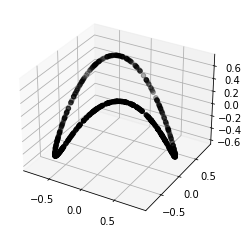

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.00048020375793167425, 0.101019697896556, 0.10493599670531477, 0.10763139734322617]
Eigengap #1: 210.36840347036514


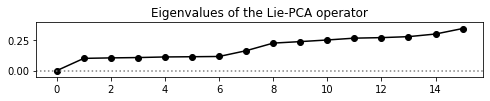

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 5
The optimal frequencies found is ((1, 2),) with cost 0.00017223463963309118
----> The frequencies ((1, 2),) and ((1, 2),) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0931


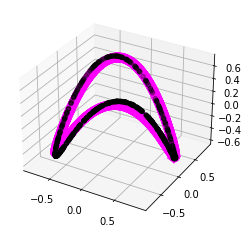

In [7]:
' Project in minimal-dimensional subspace '

# Prune small PCA eigenvalues
eps_pca = 1e-10
pca = sklearn.decomposition.PCA(n_components=ambient_dim); pca.fit(X)
dim_pca = sum(pca.explained_variance_ratio_>eps_pca)
print('Projection in dimension', dim_pca, '- PCA eigenvalues:', sorted(pca.explained_variance_ratio_))

# Dimension reduction via PCA
pca = sklearn.decomposition.PCA(n_components=dim_pca); 
X = pca.fit_transform(X)
ambient_dim = dim_pca

# Define new frequencies (groundtruth)
Frequencies = ((1,2),)

# Plot new orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black'); plt.show();

' Lie-PCA '

n_neighbors = 10
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'NormalForm'

# Find frequencies
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 500
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot dataset
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black');
ax.scatter(Xpca[0,0], Xpca[0,1], Xpca[0,2],c='black', s=50)

# Plot estimated orbit
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=10); plt.show();

# II. Representations of $T^2$

## II.1. Representation of $T^2$ in $\mathbb{R}^6$

-----> Representation of T^2 in R^6 with frequencies ((-1, -2, 1), (-2, -2, 0))


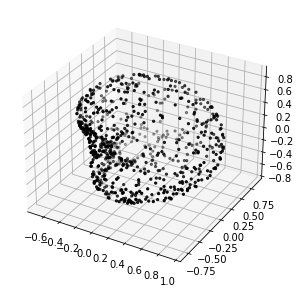

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.001293217395567441, 0.0013563303802893213, 0.06780406374958498, 0.07118289297101713]
Eigengap #2: 49.99081693880628


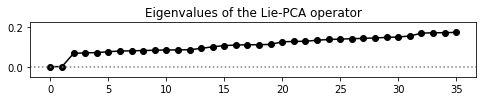

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 56
The optimal frequencies found is ((2, -1, 1), (1, 0, 1)) with cost 0.0007917292020623533
----> The frequencies ((-1, -2, 1), (-2, -2, 0)) and ((2, -1, 1), (1, 0, 1)) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0504


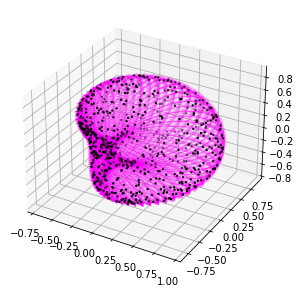

In [8]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
dim = 2             # dimension of the torus
n_points = 750      # number of sample points
frequency_max = 2   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 15
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'NormalForm'

# Find frequencies
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 150
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

## II.2. Representation of $T^2$ in $\mathbb{R}^8$

-----> Representation of T^2 in R^8 with frequencies ((2, 2, -1, 0), (2, 0, -2, 1))


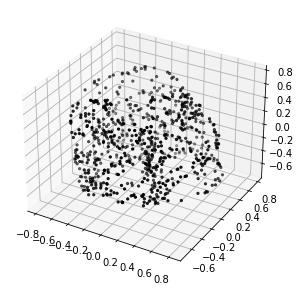

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0038887444063771797, 0.004642171333385132, 0.04379396828057152, 0.04509667755196204]
Eigengap #2: 9.433940528135654


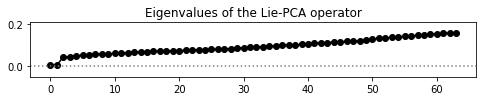

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 70
The optimal frequencies found is ((0, 2, -2, 1), (-2, 1, 0, 1)) with cost 0.046574789838993
----> The frequencies ((2, 2, -1, 0), (2, 0, -2, 1)) and ((0, 2, -2, 1), (-2, 1, 0, 1)) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.0898


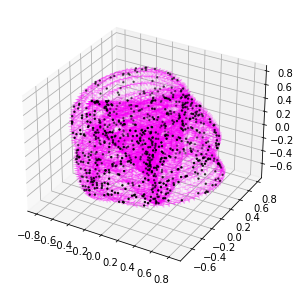

In [9]:
' Generate dataset '

# Parameters
ambient_dim = 8     # ambient dimension
dim = 2             # dimension of the torus
n_points = 750      # number of sample points
frequency_max = 2   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 15
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

# Find frequencies
method = 'NormalForm'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 150
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

# III. Representations of $T^3$

## III.1. Representation of $T^3$ in $\mathbb{R}^8$

-----> Representation of T^3 in R^8 with frequencies ((0, 1, 0, 1), (1, 1, 0, 0), (1, 1, 1, 0))


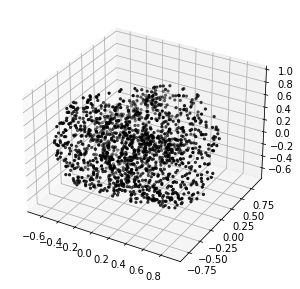

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0031847019939996953, 0.003247415473741799, 0.004092227075916789, 0.04431287346663546]
Eigengap #3: 10.828547058745016


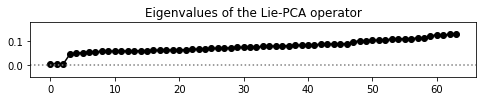

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 35
The optimal frequencies found is ((1, 1, 1, 0), (1, 0, 0, 0), (0, 1, 0, 1)) with cost 0.002915415298246532
----> The frequencies ((0, 1, 0, 1), (1, 1, 0, 0), (1, 1, 1, 0)) and ((1, 1, 1, 0), (1, 0, 0, 0), (0, 1, 0, 1)) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.1793


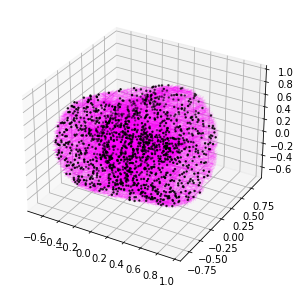

In [10]:
' Generate dataset '

# Parameters
ambient_dim = 8     # ambient dimension
dim = 3             # dimension of the torus
n_points = 1500     # number of sample points
frequency_max = 1   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 30
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'NormalForm'

# Find frequencies
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 30
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='random')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

## III.2. Representation of $T^3$ in $\mathbb{R}^{10}$

-----> Representation of T^3 in R^10 with frequencies ((1, 1, -1, 1, 0), (0, 1, -1, 0, 0), (0, 0, -1, 1, -1))


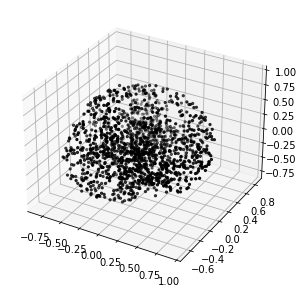

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0031575429782500874, 0.003280062526520035, 0.003564617435406773, 0.03571491887127657]
Eigengap #3: 10.01928524405621


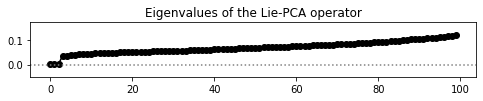

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 21
The optimal frequencies found is ((0, 0, 0, -1, 1), (-1, 0, 1, -1, 1), (0, 1, 1, 0, 1)) with cost 0.017757667272826953
----> The frequencies ((1, 1, -1, 1, 0), (0, 1, -1, 0, 0), (0, 0, -1, 1, -1)) and ((0, 0, 0, -1, 1), (-1, 0, 1, -1, 1), (0, 1, 1, 0, 1)) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.1587


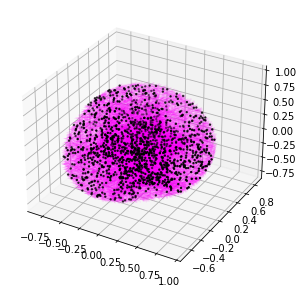

In [11]:
' Generate dataset '

# Parameters
ambient_dim = 10    # ambient dimension
dim = 3             # dimension of the torus
n_points = 1500     # number of sample points
frequency_max = 1   # maximal angle parameter

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnTorus(dim=dim, ambient_dim=ambient_dim, n_points=n_points, frequency_max=frequency_max,
                                           conjugate=True, right_multiply=True, verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 30
method = 'localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'NormalForm'

# Find frequencies
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              # FrequenciesToTest = GetFrequenciesToTest(dim=dim, ambient_dim=ambient_dim, frequency_max=frequency_max),
                                                              method=method,verbosity=1)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 30
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='random')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

# IV. Representations of $\mathrm{SU(2)}$ and $\mathrm{SO}(3)$

## IV.1. Representation of $\mathrm{SO}(3)$ in $\mathbb{R}^5$

-----> Representation of SU(2) in R^5 with partition [5]


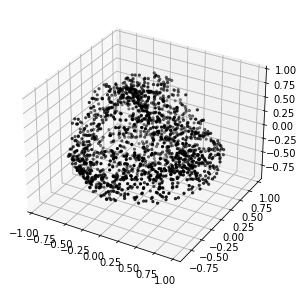

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.012879191760993395, 0.013737687366999863, 0.013866518048843458, 0.0581473464139042]
Eigengap #3: 4.193363193924086


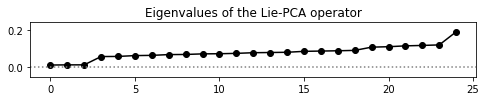

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 3/3. Duration 0:00:22 Expected remaining time 0:00:00.
The optimal frequencies found is (5,) with cost 0.0006352420442555093
Frequencies (5,) - score 0.00064 (best cost #1/3)
Frequencies (1, 1, 3) - score 0.00739 (best cost #2/3)
Frequencies (1, 4) - score 0.01009 (best cost #3/3)
----> The frequencies [5] and (5,) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.1317


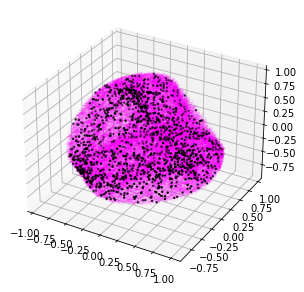

In [12]:
' Generate dataset '

# Parameters
ambient_dim = 5     # ambient dimension
group = 'SU(2)'     # Lie group considered
dim = 3             # dimension of the group

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnSU2(ambient_dim=ambient_dim, n_points=n_points, frequencies=[5], verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();
n_points = 1500     # number of sample points

' Lie-PCA '

n_neighbors = 30
method = 'localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'Stiefel' # can be 'Stiefel' or 'Grassmann'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('SU(2)',Sigma,dim,ambient_dim,method=method,verbosity=2)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 30
x = X[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

## IV.2. Representation of $\mathrm{SU}(2)$ in $\mathbb{R}^7$

-----> Representation of SU(2) in R^7 with partition [3, 4]


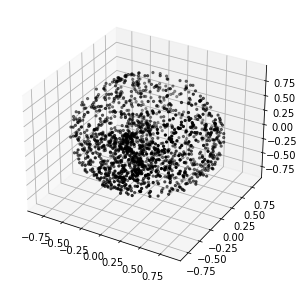

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.0017661766059082179, 0.0028389951484685825, 0.002958049904377698, 0.0032328223296856124]
Eigengap #3: 1.0928897193050298


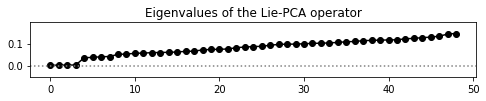

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 6/6. Duration 0:39:14 Expected remaining time 0:00:00.
The optimal frequencies found is (3, 4) with cost 3.8329614618100445e-05
Frequencies (3, 4) - score 4e-05 (best cost #1/6)
Frequencies (1, 1, 5) - score 0.0036 (best cost #2/6)
Frequencies (1, 3, 3) - score 0.00378 (best cost #3/6)
Frequencies (7,) - score 0.00665 (best cost #4/6)
Frequencies (1, 1, 1, 1, 3) - score 0.00851 (best cost #5/6)
Frequencies (1, 1, 1, 4) - score 0.01417 (best cost #6/6)
----> The frequencies [3, 4] and (3, 4) are equivalent <----
Non-symmetric Hausdorff distance from X to estimated orbit: 0.1206


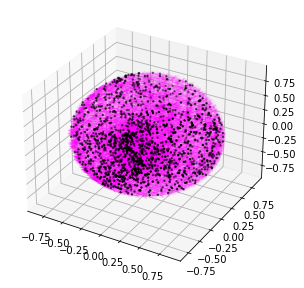

In [13]:
' Generate dataset '

# Parameters
ambient_dim = 7     # ambient dimension
group = 'SU(2)'     # Lie group considered
dim = 3             # dimension of the group
n_points = 1500     # number of sample points

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnSU2(ambient_dim=ambient_dim, n_points=n_points, frequencies=[3,4],verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 30
method = 'localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

' Project on Lie subalgebras '

method = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('SU(2)',Sigma,dim,ambient_dim,method=method,verbosity=2)

# Check if found frequencies are correct
AreFrequencesEquivalent(Frequencies,OptimalFrequencies,verbose=True)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 30
x = X[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

# V. Additional experiments

## V.1. Comparison of two candidates: $\mathrm{SO}(3)$ and $T^3$ in $\mathbb{R}^6$

We sample on an orbit of the group $\mathrm{SO}(3)$ in $\mathbb{R}^6$. We suppose the group unknown.

-----> Representation of SU(2) in R^6 with partition [1, 5]


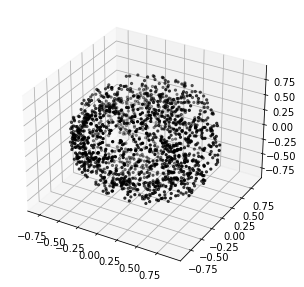

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.009289024266117949, 0.010447210402232444, 0.012010660639338354, 0.03572721514498532]
Eigengap #3: 2.97462531144777


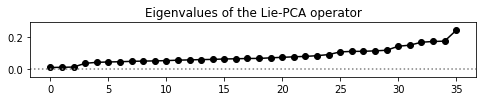

In [14]:
' Generate dataset '

# Parameters
ambient_dim = 6     # ambient dimension
group = 'SU(2)'     # Lie group considered
dim = 3             # dimension of the group
n_points = 1500     # number of sample points

# Generate dataset and plot
X, LieAlgebra, Frequencies = SampleOnSU2(ambient_dim=ambient_dim, n_points=n_points, frequencies=[1,5],verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 30
method = 'localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

LiePCA suggest a symmetry group of dimension 3. We first test the torus.

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 29
The optimal frequencies found is ((0, 0, 1), (0, 1, 0), (1, 0, 0)) with cost 3.236828524569469e-16
Non-symmetric Hausdorff distance from X to estimated orbit: 1.1581


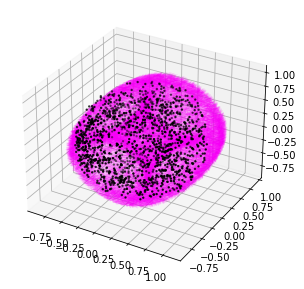

In [15]:
' Project on Lie subalgebras -T3 '

# Find frequencies
method = 'NormalForm'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=1,method=method,verbosity=1)

# Generate estimated orbit
n_points_orbit = 30
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='random')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

The algorithm seems to fail. However, with the group $\mathrm{SU}(2)$, a correct fit is observed.

----> Optimization problem via Stiefel for SU(2) group <----
Solve minimization problem... It 4/4. Duration 0:04:52 Expected remaining time 0:00:00.
The optimal frequencies found is (1, 5) with cost 0.0005081963619261212
Frequencies (1, 5) - score 0.00051 (best cost #1/4)
Frequencies (1, 1, 1, 3) - score 0.0054 (best cost #2/4)
Frequencies (1, 1, 4) - score 0.007 (best cost #3/4)
Frequencies (3, 3) - score 0.01496 (best cost #4/4)
Non-symmetric Hausdorff distance from X to estimated orbit: 0.1163


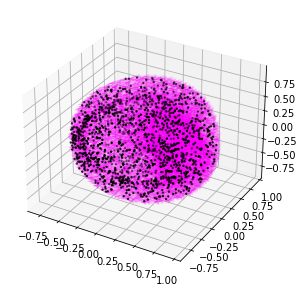

In [16]:
' Project on Lie subalgebras - SU(2) '

method = 'Stiefel'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('SU(2)',Sigma,dim,ambient_dim,method=method,verbosity=2)

# Generate estimated orbit
n_points_orbit = 30
x = X[0,:] #initial point of X
Orbit = GenerateOrbitSU2(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.1,marker="3");

## V.2. Non-transitive action: Möbius strip $\mathbb{R}^4$

In [17]:
import gudhi

def SampleOnMobiusStrip(N_points_init, N_points_subsample):
    r = 1 #parameter 

    # Draw sample from uniform distribution
    Sample = []
    Angles = np.array([np.random.uniform(0,2*np.pi,N_points_init) for i in range(2)])
    for i in range(N_points_init): 
        theta, phi = Angles[:,i]
        s = np.array([np.cos(theta),np.sin(theta),r*np.cos(phi)*np.cos(theta/2),r*np.cos(phi)*np.sin(theta/2) ])
        Sample.append(s)

    # Subsample with gudhi    
    Sample = np.array(gudhi.subsampling.choose_n_farthest_points(points=Sample, nb_points = N_points_subsample))
    
    return Sample

We sample 500 points on the Möbius strip, embedded in $\mathbb{R}^4$.

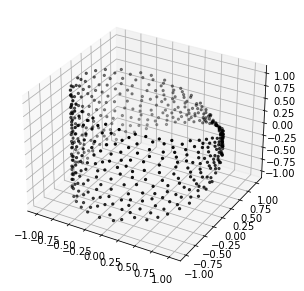

----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.00023477937573671118, 0.00045725478795446707, 0.05250475379458934, 0.05356808730325613]
Eigengap #2: 114.82603392622694


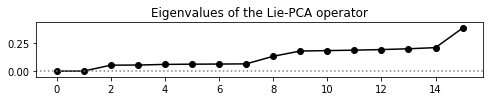

In [18]:
' Generate dataset '

# Generate sample
N_points_init, N_points_subsample = 10000, 500
X = SampleOnMobiusStrip(N_points_init, N_points_subsample)

# Plot
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black',s=5); plt.show();

' Lie-PCA '

n_neighbors = 15
dim = 2
method='localPCA'
Sigma = GetLiePCAOperator(X,n_neighbors,dim=dim,method=method)

# Plot Lie-PCA operator
vals = np.sort(np.real(np.linalg.eig(Sigma)[0])) #find eigenvalues and vectors of sigma as a matrix
fig = plt.figure(figsize=(8,1)); ax = fig.add_subplot()
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black'); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.05,max(vals)+0.05)); ax.set_title('Eigenvalues of the Lie-PCA operator'); plt.show();

LiePCA suggest a symmetry group of dimension 2. We test the torus.

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 25
The optimal frequencies found is ((0, 1), (1, 0)) with cost 0.0
Non-symmetric Hausdorff distance from X to estimated orbit: 1.2094


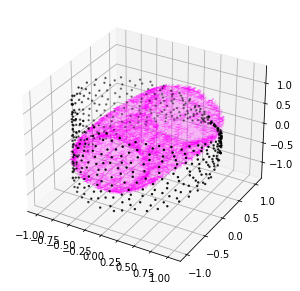

In [19]:
' LieDetect - T^2 '

# Find frequencies
dim = 2 # dimension of the torus
ambient_dim = 4
method = 'NormalForm'
frequency_max = 2
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus',Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

' Plot orbit '

# Generate estimated orbit
n_points_orbit = 50
x = X[0,:] #initial point of X
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='random')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Xpca = pca.fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.25,marker="3");

The algorithm seems to fail. Actually, the Möbius strip only supports an action of $\mathrm{SO}(2)$.
As seen in the following cell, this action is successfully retrieved: each point generates an orbit that stays within the points cloud.

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 1
The optimal frequencies found is ((1, 2),) with cost 0.03247820232477886
Non-symmetric Hausdorff distance from X to estimated orbit: 0.7815
Non-symmetric Hausdorff distance from estimated orbit to X: 0.1312


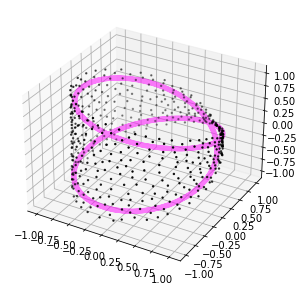

Non-symmetric Hausdorff distance from X to estimated orbit: 0.6763
Non-symmetric Hausdorff distance from estimated orbit to X: 0.1497


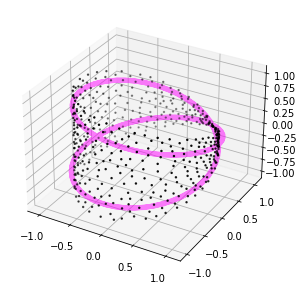

Non-symmetric Hausdorff distance from X to estimated orbit: 1.027
Non-symmetric Hausdorff distance from estimated orbit to X: 0.1394


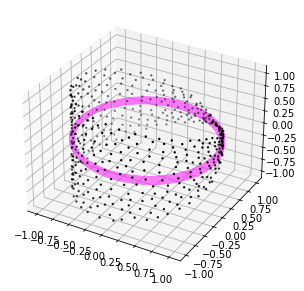

Non-symmetric Hausdorff distance from X to estimated orbit: 0.589
Non-symmetric Hausdorff distance from estimated orbit to X: 0.1315


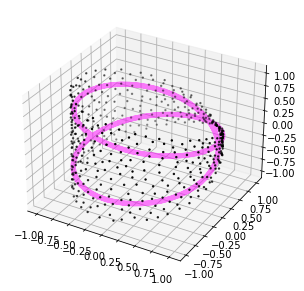

In [20]:
' LieDetect - SO(2) '

# Find frequencies
dim = 1 # dimension of the torus
ambient_dim = 4
method = 'NormalForm'
frequency_max = 2
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus',Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

' Plot orbit '

for i in [0, 50, 100, 150]:
    # Generate estimated orbit
    n_points_orbit = 100
    x = X[i,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')
    
    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(X, Orbit)[0]
    print('Non-symmetric Hausdorff distance from X to estimated orbit:', round(Hausdorff,4))
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit,X)[0]
    print('Non-symmetric Hausdorff distance from estimated orbit to X:', round(Hausdorff,4))
    
    # Plot orbit
    pca = sklearn.decomposition.PCA(n_components=3)
    Xpca = pca.fit_transform(X)
    fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
    ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=2);
    Orbitpca = pca.transform(Orbit)
    ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=5, alpha=0.5); plt.show()